In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import sys
import os
import xgboost as xgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import catboost as cat

path = '/home/alexandr/Desktop/study/boosterspro/happy_data_year_rosbank/'
sys.path.append(path) if not path in sys.path else None
import src.utils as utils
from src.model import AveragingModel
import src.location_features as lf


%load_ext autoreload
%autoreload 2

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
train = pd.read_csv(path+'data/input/train.csv', index_col=0)

In [4]:
test = pd.read_csv(path+'data/input/test.csv', index_col=0)

In [5]:
train['isTrain'] = True
test['isTrain'] = False

In [6]:
X = train.append(test, sort=False)

In [7]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [8]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


### Количество банкоматов стоящих по одному адресу

In [9]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [10]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [11]:
X.head()

,id,atm_group,address,address_rus,lat,long,target,isTrain,count
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0


### Расстояния до ближайших банкоматов

In [12]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [13]:
knc = KNeighborsClassifier(metric=distance)

In [14]:
dots = X[['lat','long']].dropna()

In [15]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7f18120bf378>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [17]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [18]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)
dots = dots.drop(columns=['lat', 'long'])

In [19]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [152]:
X = lf.cities(X)

In [154]:
X.columns

Index(['id', 'atm_group', 'address', 'address_rus', 'lat', 'long', 'target',
       'isTrain', 'count', 'distance_1', 'indexes_1', 'distance_2',
       'indexes_2', 'distance_3', 'indexes_3', 'distance_4', 'indexes_4',
       'distance_5', 'indexes_5', 'mean', 'city', 'loc_0', 'loc_1', 'loc_2',
       'loc_3', 'loc_4', 'city_people', 'city_lat', 'city_long', 'city_dist'],
      dtype='object')

## Facilities

In [104]:
N = 5
fac = lf.facilities(X[['lat', 'long']].dropna(), 'loc', N)
loc_inds = list('loc_'+str(i) for i in range(N))

In [105]:
for i in range(N):
    X['loc_'+str(i)] = np.nan

In [106]:
X.loc[np.where(~X.lat.isna())[0], loc_inds] = fac.values

In [124]:
X

,id,atm_group,address,address_rus,lat,long,target,isTrain,count,distance_1,...,indexes_4,distance_5,indexes_5,mean,city,loc_0,loc_1,loc_2,loc_3,loc_4
0,8526.0,32,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,True,1.0,0.171318,...,2802.0,0.558967,8335.0,0.409042,5272,0.581618,0.829560,0.844973,1.034242,1.077008
1,8532.0,32,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,True,1.0,0.243277,...,6023.0,0.903549,4770.0,0.647652,5272,0.092352,0.322993,0.535269,0.668820,0.749278
2,8533.0,32,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,True,1.0,0.221691,...,1648.0,0.495823,6738.0,0.316629,6926,0.224745,0.476143,0.526811,0.581398,0.638686
3,8684.0,32,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,True,1.0,0.371956,...,6852.0,0.820951,4767.0,0.647866,2212,0.048052,0.051015,0.111783,0.111959,0.116945
4,37.0,32,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,True,1.0,0.199516,...,2196.0,0.878445,1013.0,0.490170,3152,0.091065,0.100599,0.119550,0.142957,0.152484
5,313.0,32,"RUSSKAYA, 16 VLADIVOSTOK","Русская улица, 16, Владивосток, Приморский кра...",43.165860,131.908212,-0.145001,True,1.0,0.164126,...,5183.0,0.322592,4415.0,0.273942,493,0.061908,0.099588,0.101754,0.119724,0.162459
6,335.0,32,"SHUKHOVA, 14 MOSCOW","улица Шухова, 14, Москва, Россия, 115162",55.716859,37.613063,-0.024682,True,1.0,0.518512,...,7138.0,0.926298,2722.0,0.806350,2212,0.244661,0.244915,0.273703,0.277645,0.297509
7,358.0,32,"ADMIRALA FOKINA, 25 VLADIVOSTOK","улица Адмирала Фокина, 25, Владивосток, Примор...",43.117174,131.885503,-0.133426,True,1.0,0.088530,...,8214.0,0.145161,2619.0,0.110467,493,0.034639,0.065413,0.085205,0.119131,0.124723
8,2895.0,32,Zhivopisnaia 136 d.Velednikov,"деревня Веледниково, городской округ Истра, Мо...",55.799765,37.116016,0.141469,True,1.0,3.011627,...,780.0,6.673520,690.0,5.613069,2611,1.419874,1.434124,1.527103,1.662025,1.840775
9,1975.0,496,BEKESHSKAYA 39 PENZA,"Бекешская улица, 39, Пенза, Россия, 440018",53.203220,44.978826,0.017259,True,1.0,0.632477,...,4524.0,1.159673,4519.0,0.866205,3437,0.197085,0.227478,0.237323,0.245288,0.253825


## Train / test

In [155]:
columns = ['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'mean', 'city', 'city_people', 'city_lat', 
                    'city_long', 'city_dist'] + loc_inds

X['atm_group'] = X['atm_group'].astype(int)
X['city'] = X['city'].astype(int)

X_ = X[X.isTrain][columns]
Y_ = X.loc[X.isTrain, 'target']

In [156]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_, Y_, test_size=0.25, random_state=2)

## LightGBM

In [157]:

def train(depth=12, n_estimators=150):
    gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = depth,
                            num_iterations=1000,
                            learning_rate = 0.1,
                            num_leaves = 2**(depth-1),
                            boosting = 'gbdt',
                            n_estimators = n_estimators)
    gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)
    score = rmse(Y_valid, gbm.predict(X_valid))
    return gbm, score
scores = []
models = []
for depth in tqdm_notebook(range(3, 12)):
    model, score = train(depth)
    models.append(model)
    scores.append(score)
    
opt_depth = 5+np.argmin(scores)
gbm_model = models[np.argmin(scores)]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.0809941	valid_0's l2: 0.00656004
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0762168	valid_0's l2: 0.005809
[3]	valid_0's rmse: 0.0721005	valid_0's l2: 0.00519848
[4]	valid_0's rmse: 0.0685576	valid_0's l2: 0.00470014
[5]	valid_0's rmse: 0.0655048	valid_0's l2: 0.00429088
[6]	valid_0's rmse: 0.0628984	valid_0's l2: 0.00395621
[7]	valid_0's rmse: 0.06064	valid_0's l2: 0.00367721
[8]	valid_0's rmse: 0.0585285	valid_0's l2: 0.00342558
[9]	valid_0's rmse: 0.0569271	valid_0's l2: 0.0032407
[10]	valid_0's rmse: 0.0555741	valid_0's l2: 0.00308848
[11]	valid_0's rmse: 0.0542232	valid_0's l2: 0.00294015
[12]	valid_0's rmse: 0.0532259	valid_0's l2: 0.002833
[13]	valid_0's rmse: 0.052379	valid_0's l2: 0.00274356
[14]	valid_0's rmse: 0.0515142	valid_0's l2: 0.00265372
[15]	valid_0's rmse: 0.0509208	valid_0's l2: 0.00259292
[16]	valid_0's rmse: 0.0504079	valid_0's l2: 0.00254096
[17]	valid_0's rmse: 0.0499702	valid_0's l2: 0.00249702
[18]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.0807407	valid_0's l2: 0.00651907
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0757577	valid_0's l2: 0.00573922
[3]	valid_0's rmse: 0.0714092	valid_0's l2: 0.00509927
[4]	valid_0's rmse: 0.0677135	valid_0's l2: 0.00458512
[5]	valid_0's rmse: 0.0645053	valid_0's l2: 0.00416093
[6]	valid_0's rmse: 0.0617661	valid_0's l2: 0.00381505
[7]	valid_0's rmse: 0.0594542	valid_0's l2: 0.00353481
[8]	valid_0's rmse: 0.0574526	valid_0's l2: 0.0033008
[9]	valid_0's rmse: 0.0556428	valid_0's l2: 0.00309612
[10]	valid_0's rmse: 0.0540124	valid_0's l2: 0.00291734
[11]	valid_0's rmse: 0.0527761	valid_0's l2: 0.00278532
[12]	valid_0's rmse: 0.0516413	valid_0's l2: 0.00266682
[13]	valid_0's rmse: 0.0507629	valid_0's l2: 0.00257687
[14]	valid_0's rmse: 0.0499316	valid_0's l2: 0.00249317
[15]	valid_0's rmse: 0.0492148	valid_0's l2: 0.00242209
[16]	valid_0's rmse: 0.0486192	valid_0's l2: 0.00236382
[17]	valid_0's rmse: 0.0480964	valid_0's l2: 0.002313

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's rmse: 0.0451313	valid_0's l2: 0.00203683
[25]	valid_0's rmse: 0.0450285	valid_0's l2: 0.00202757
[26]	valid_0's rmse: 0.0448918	valid_0's l2: 0.00201527
[27]	valid_0's rmse: 0.0447274	valid_0's l2: 0.00200054
[28]	valid_0's rmse: 0.0446439	valid_0's l2: 0.00199308
[29]	valid_0's rmse: 0.0445045	valid_0's l2: 0.00198065
[30]	valid_0's rmse: 0.0444707	valid_0's l2: 0.00197764
[31]	valid_0's rmse: 0.0444082	valid_0's l2: 0.00197208
[32]	valid_0's rmse: 0.0443155	valid_0's l2: 0.00196386
[33]	valid_0's rmse: 0.0442597	valid_0's l2: 0.00195892
[34]	valid_0's rmse: 0.0442434	valid_0's l2: 0.00195748
[35]	valid_0's rmse: 0.0442271	valid_0's l2: 0.00195604
[36]	valid_0's rmse: 0.0441989	valid_0's l2: 0.00195355
[37]	valid_0's rmse: 0.0441564	valid_0's l2: 0.00194979
[38]	valid_0's rmse: 0.0440841	valid_0's l2: 0.0019434
[39]	valid_0's rmse: 0.0440314	valid_0's l2: 0.00193877
[40]	valid_0's rmse: 0.0439795	valid_0's l2: 0.00193419
[41]	valid_0's rmse: 0.0439212	valid_0's l2: 0.00

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.0804824	valid_0's l2: 0.00647742
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0752506	valid_0's l2: 0.00566265
[3]	valid_0's rmse: 0.0706998	valid_0's l2: 0.00499846
[4]	valid_0's rmse: 0.066754	valid_0's l2: 0.0044561
[5]	valid_0's rmse: 0.0633906	valid_0's l2: 0.00401837
[6]	valid_0's rmse: 0.0604766	valid_0's l2: 0.00365742
[7]	valid_0's rmse: 0.0579877	valid_0's l2: 0.00336257
[8]	valid_0's rmse: 0.0557699	valid_0's l2: 0.00311028
[9]	valid_0's rmse: 0.053921	valid_0's l2: 0.00290747
[10]	valid_0's rmse: 0.0524226	valid_0's l2: 0.00274813
[11]	valid_0's rmse: 0.0511385	valid_0's l2: 0.00261515
[12]	valid_0's rmse: 0.0500288	valid_0's l2: 0.00250288
[13]	valid_0's rmse: 0.0490951	valid_0's l2: 0.00241033
[14]	valid_0's rmse: 0.0482935	valid_0's l2: 0.00233227
[15]	valid_0's rmse: 0.0476062	valid_0's l2: 0.00226635
[16]	valid_0's rmse: 0.0469934	valid_0's l2: 0.00220838
[17]	valid_0's rmse: 0.0465064	valid_0's l2: 0.00216284

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.080374	valid_0's l2: 0.00645997
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0750346	valid_0's l2: 0.00563019
[3]	valid_0's rmse: 0.0704458	valid_0's l2: 0.00496262
[4]	valid_0's rmse: 0.0664237	valid_0's l2: 0.00441211
[5]	valid_0's rmse: 0.0630274	valid_0's l2: 0.00397246
[6]	valid_0's rmse: 0.0601002	valid_0's l2: 0.00361203
[7]	valid_0's rmse: 0.057565	valid_0's l2: 0.00331373
[8]	valid_0's rmse: 0.0554105	valid_0's l2: 0.00307033
[9]	valid_0's rmse: 0.0535053	valid_0's l2: 0.00286282
[10]	valid_0's rmse: 0.0519092	valid_0's l2: 0.00269457
[11]	valid_0's rmse: 0.0506647	valid_0's l2: 0.00256691
[12]	valid_0's rmse: 0.0494858	valid_0's l2: 0.00244885
[13]	valid_0's rmse: 0.0485752	valid_0's l2: 0.00235955
[14]	valid_0's rmse: 0.0477889	valid_0's l2: 0.00228378
[15]	valid_0's rmse: 0.0471148	valid_0's l2: 0.00221981
[16]	valid_0's rmse: 0.0466041	valid_0's l2: 0.00217194
[17]	valid_0's rmse: 0.04608	valid_0's l2: 0.00212337


/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's rmse: 0.062922	valid_0's l2: 0.00395917
[6]	valid_0's rmse: 0.0599312	valid_0's l2: 0.00359174
[7]	valid_0's rmse: 0.0573646	valid_0's l2: 0.0032907
[8]	valid_0's rmse: 0.0552106	valid_0's l2: 0.00304821
[9]	valid_0's rmse: 0.0533919	valid_0's l2: 0.0028507
[10]	valid_0's rmse: 0.0518123	valid_0's l2: 0.00268451
[11]	valid_0's rmse: 0.0505312	valid_0's l2: 0.0025534
[12]	valid_0's rmse: 0.0494222	valid_0's l2: 0.00244255
[13]	valid_0's rmse: 0.0485166	valid_0's l2: 0.00235386
[14]	valid_0's rmse: 0.0477169	valid_0's l2: 0.00227691
[15]	valid_0's rmse: 0.0470489	valid_0's l2: 0.0022136
[16]	valid_0's rmse: 0.0465152	valid_0's l2: 0.00216367
[17]	valid_0's rmse: 0.0460793	valid_0's l2: 0.0021233
[18]	valid_0's rmse: 0.0456859	valid_0's l2: 0.0020872
[19]	valid_0's rmse: 0.0454419	valid_0's l2: 0.00206497
[20]	valid_0's rmse: 0.0451726	valid_0's l2: 0.00204057
[21]	valid_0's rmse: 0.0449171	valid_0's l2: 0.00201755
[22]	valid_0's rmse: 0.0447283	valid_0's l2: 0.00200062
[23]

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[8]	valid_0's rmse: 0.0551939	valid_0's l2: 0.00304636
[9]	valid_0's rmse: 0.0533349	valid_0's l2: 0.00284461
[10]	valid_0's rmse: 0.0517765	valid_0's l2: 0.00268081
[11]	valid_0's rmse: 0.0504587	valid_0's l2: 0.00254608
[12]	valid_0's rmse: 0.0493325	valid_0's l2: 0.00243369
[13]	valid_0's rmse: 0.0483196	valid_0's l2: 0.00233478
[14]	valid_0's rmse: 0.0475935	valid_0's l2: 0.00226514
[15]	valid_0's rmse: 0.0469186	valid_0's l2: 0.00220135
[16]	valid_0's rmse: 0.0463388	valid_0's l2: 0.00214728
[17]	valid_0's rmse: 0.0459198	valid_0's l2: 0.00210863
[18]	valid_0's rmse: 0.0455739	valid_0's l2: 0.00207698
[19]	valid_0's rmse: 0.045299	valid_0's l2: 0.002052
[20]	valid_0's rmse: 0.0450172	valid_0's l2: 0.00202655
[21]	valid_0's rmse: 0.0448026	valid_0's l2: 0.00200727
[22]	valid_0's rmse: 0.0446519	valid_0's l2: 0.00199379
[23]	valid_0's rmse: 0.0445534	valid_0's l2: 0.00198501
[24]	valid_0's rmse: 0.0443738	valid_0's l2: 0.00196904
[25]	valid_0's rmse: 0.0442385	valid_0's l2: 0.00195

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's rmse: 0.0748789	valid_0's l2: 0.00560685
[3]	valid_0's rmse: 0.070184	valid_0's l2: 0.0049258
[4]	valid_0's rmse: 0.0661914	valid_0's l2: 0.0043813
[5]	valid_0's rmse: 0.0627937	valid_0's l2: 0.00394305
[6]	valid_0's rmse: 0.0598195	valid_0's l2: 0.00357837
[7]	valid_0's rmse: 0.0572077	valid_0's l2: 0.00327272
[8]	valid_0's rmse: 0.0550692	valid_0's l2: 0.00303261
[9]	valid_0's rmse: 0.053247	valid_0's l2: 0.00283524
[10]	valid_0's rmse: 0.0516781	valid_0's l2: 0.00267063
[11]	valid_0's rmse: 0.050337	valid_0's l2: 0.00253381
[12]	valid_0's rmse: 0.0492144	valid_0's l2: 0.00242205
[13]	valid_0's rmse: 0.0482977	valid_0's l2: 0.00233267
[14]	valid_0's rmse: 0.0475207	valid_0's l2: 0.00225822
[15]	valid_0's rmse: 0.0468751	valid_0's l2: 0.00219728
[16]	valid_0's rmse: 0.0462677	valid_0's l2: 0.0021407
[17]	valid_0's rmse: 0.0457838	valid_0's l2: 0.00209615
[18]	valid_0's rmse: 0.0454158	valid_0's l2: 0.0020626
[19]	valid_0's rmse: 0.0450622	valid_0's l2: 0.0020306
[20]	val

/home/alexandr/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 0.0803166	valid_0's l2: 0.00645075
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0748624	valid_0's l2: 0.00560438
[3]	valid_0's rmse: 0.0701723	valid_0's l2: 0.00492415
[4]	valid_0's rmse: 0.0661344	valid_0's l2: 0.00437376
[5]	valid_0's rmse: 0.0627217	valid_0's l2: 0.00393401
[6]	valid_0's rmse: 0.0596767	valid_0's l2: 0.00356131
[7]	valid_0's rmse: 0.0570998	valid_0's l2: 0.00326039
[8]	valid_0's rmse: 0.0549406	valid_0's l2: 0.00301847
[9]	valid_0's rmse: 0.053069	valid_0's l2: 0.00281632
[10]	valid_0's rmse: 0.0514931	valid_0's l2: 0.00265154
[11]	valid_0's rmse: 0.0502133	valid_0's l2: 0.00252137
[12]	valid_0's rmse: 0.0490744	valid_0's l2: 0.0024083
[13]	valid_0's rmse: 0.0480995	valid_0's l2: 0.00231356
[14]	valid_0's rmse: 0.0473206	valid_0's l2: 0.00223924
[15]	valid_0's rmse: 0.0466828	valid_0's l2: 0.00217928
[16]	valid_0's rmse: 0.0461175	valid_0's l2: 0.00212682
[17]	valid_0's rmse: 0.0456784	valid_0's l2: 0.0020865

0.04254586891038471 0.04254586891038471


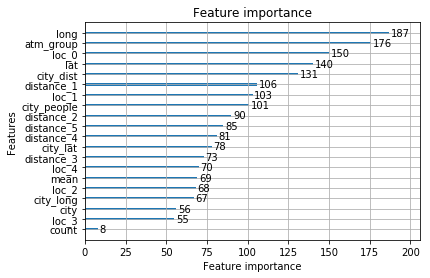

In [158]:
lgb.plot_importance(gbm_model)
print(rmse(Y_valid, gbm_model.predict(X_valid)), scores[opt_depth-5])

## XGBoost


In [159]:
def train_xgb(params, X_train, Y_train):
    xg_reg = xgb.XGBRegressor(**params)
    xg_reg.fit(X_train, Y_train)
    score = rmse(Y_valid, xg_reg.predict(X_valid))
    return xg_reg, score

In [160]:
scores = []
models = []

conf = {
    'seed': 1,
    'subsample': 0.8,
    'max_depth': 7,
    'n_estimators': 150,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

for depth in tqdm_notebook(range(4, 8)):
    for n_estimators in range(100, 250, 20):
        conf['max_depth'] = depth
        conf['n_estimators'] = n_estimators
        model, score = train_xgb(conf, X_train, Y_train)
        models.append(model)
        scores.append(score)
        print('num of estimators:', n_estimators,
              'depth:', depth, 
              'score:', score, '\n')

xgb_model = models[np.argmin(scores)]
score = scores[np.argmin(scores)]

num of estimators: 100 depth: 4 score: 0.0431892467078944 

num of estimators: 120 depth: 4 score: 0.04308408908055936 

num of estimators: 140 depth: 4 score: 0.04309870261665259 

num of estimators: 160 depth: 4 score: 0.043029315145402404 

num of estimators: 180 depth: 4 score: 0.042918043149492324 

num of estimators: 200 depth: 4 score: 0.042840243539181734 

num of estimators: 220 depth: 4 score: 0.04285485062541424 

num of estimators: 240 depth: 4 score: 0.0428488832153992 

num of estimators: 100 depth: 5 score: 0.042848084293198994 

num of estimators: 120 depth: 5 score: 0.04280753937037439 

num of estimators: 140 depth: 5 score: 0.042787381204620244 

num of estimators: 160 depth: 5 score: 0.04272460130569984 

num of estimators: 180 depth: 5 score: 0.042804776652823506 

num of estimators: 200 depth: 5 score: 0.04287116051969904 

num of estimators: 220 depth: 5 score: 0.042989218747606604 

num of estimators: 240 depth: 5 score: 0.04305775657071129 

num of estimators: 

0.04262400493755149 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=True, subsample=0.8)


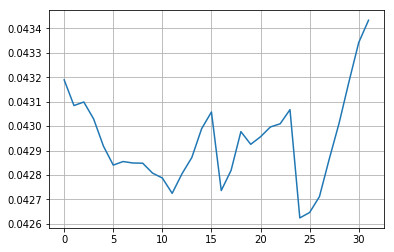

In [161]:
print(score, '\n', xgb_model)
plt.plot(scores)
plt.grid()

## Catboost

In [162]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [163]:
categorical_features = ['atm_group', 'city']
categorical_index = column_index(X_train, categorical_features)
categorical_index

array([ 0, 10])

In [164]:
def train_catboost(depth, X_train, Y_train, X_valid, Y_valid):
    cat_model = cat.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=depth,
        eval_metric='RMSE',
        random_seed=1,
        od_type='Iter',
        metric_period=75,
    )


    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid),
                 cat_features=categorical_index,
                 use_best_model=True)
    
    score = rmse(Y_valid, cat_model.predict(X_valid))
    return cat_model, score

    
scores = []
models = []

for depth in tqdm_notebook(range(4, 10)):
    model, score = train_catboost(depth, X_train, Y_train, X_valid, Y_valid)
    models.append(model)
    scores.append(score)
    print('depth:', depth, 
          'score:', score, '\n')

cat_model = models[np.argmin(scores)]
score = scores[np.argmin(scores)]
print(score, cat_model)

0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 16.7ms	remaining: 16.7s
75:	learn: 0.0464036	test: 0.0444848	best: 0.0444848 (75)	total: 642ms	remaining: 7.81s
150:	learn: 0.0451214	test: 0.0439621	best: 0.0439555 (147)	total: 1.15s	remaining: 6.47s
225:	learn: 0.0441851	test: 0.0437568	best: 0.0437523 (221)	total: 1.63s	remaining: 5.59s
300:	learn: 0.0435365	test: 0.0436346	best: 0.0436308 (285)	total: 2.11s	remaining: 4.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04363077541
bestIteration = 285

Shrink model to first 286 iterations.
depth: 4 score: 0.04363077536086147 



0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 25.4ms	remaining: 25.4s
75:	learn: 0.0456890	test: 0.0442974	best: 0.0442974 (75)	total: 834ms	remaining: 10.1s
150:	learn: 0.0441715	test: 0.0437898	best: 0.0437834 (145)	total: 1.79s	remaining: 10.1s
225:	learn: 0.0433300	test: 0.0434800	best: 0.0434800 (225)	total: 2.72s	remaining: 9.32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.0434565103
bestIteration = 232

Shrink model to first 233 iterations.
depth: 5 score: 0.043456510262256255 



0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 46.8ms	remaining: 46.7s
75:	learn: 0.0451444	test: 0.0440467	best: 0.0440467 (75)	total: 1.11s	remaining: 13.5s
150:	learn: 0.0435897	test: 0.0436111	best: 0.0436111 (150)	total: 2.16s	remaining: 12.2s
225:	learn: 0.0422034	test: 0.0432918	best: 0.0432918 (225)	total: 3.3s	remaining: 11.3s
300:	learn: 0.0413659	test: 0.0431021	best: 0.0430975 (289)	total: 4.43s	remaining: 10.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04309751293
bestIteration = 289

Shrink model to first 290 iterations.
depth: 6 score: 0.04309751288923211 



0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 32.7ms	remaining: 32.6s
75:	learn: 0.0448538	test: 0.0440850	best: 0.0440794 (73)	total: 1.62s	remaining: 19.8s
150:	learn: 0.0432606	test: 0.0434982	best: 0.0434982 (150)	total: 2.9s	remaining: 16.3s
225:	learn: 0.0419563	test: 0.0432268	best: 0.0432262 (224)	total: 4.79s	remaining: 16.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04318069917
bestIteration = 254

Shrink model to first 255 iterations.
depth: 7 score: 0.04318069912678763 



0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 64.5ms	remaining: 1m 4s
75:	learn: 0.0442650	test: 0.0437597	best: 0.0437597 (75)	total: 2.77s	remaining: 33.7s
150:	learn: 0.0424434	test: 0.0433303	best: 0.0433303 (150)	total: 5.13s	remaining: 28.9s
225:	learn: 0.0409654	test: 0.0432030	best: 0.0431888 (209)	total: 8.22s	remaining: 28.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04315393495
bestIteration = 247

Shrink model to first 248 iterations.
depth: 8 score: 0.04315393491258468 



0:	learn: 0.0801907	test: 0.0808518	best: 0.0808518 (0)	total: 26.3ms	remaining: 26.3s
75:	learn: 0.0439789	test: 0.0438470	best: 0.0438470 (75)	total: 4.41s	remaining: 53.6s
150:	learn: 0.0421035	test: 0.0432916	best: 0.0432916 (150)	total: 8.03s	remaining: 45.1s
225:	learn: 0.0406169	test: 0.0431191	best: 0.0431191 (225)	total: 12.9s	remaining: 44.1s
300:	learn: 0.0397288	test: 0.0430262	best: 0.0430163 (298)	total: 16.8s	remaining: 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04292320385
bestIteration = 340

Shrink model to first 341 iterations.
depth: 9 score: 0.04292320381388896 




## Composite Models

### Averaging model

In [165]:
xgb_weights = np.linspace(0, 1, 20)
scores = []
av_models = []
for i, xgb_weight in enumerate(xgb_weights):
    for j, cat_weight in enumerate(np.linspace(0, xgb_weight, 10)):
        av_model = AveragingModel([xgb_model, gbm_model, cat_model], 
                                  pretrained=True,
                                 weights=(xgb_weight, 1-xgb_weight-cat_weight, cat_weight))
        score = rmse(Y_valid, av_model.predict(X_valid))
        scores.append(score)
        av_models.append(av_model)
        print('score:', score)


score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04254586884214701
score: 0.04246194111625734
score: 0.042457092525039285
score: 0.0424523292938459
score: 0.042447651396952675
score: 0.04244305876556346
score: 0.042438551135953885
score: 0.04243412915070695
score: 0.04242979240382594
score: 0.04242554105581426
score: 0.04242137522789921
score: 0.0423876580812343
score: 0.042378470712298805
score: 0.042369625307523216
score: 0.042361121772243694
score: 0.042352960475677576
score: 0.04234514140669388
score: 0.04233766524427368
score: 0.04233053147268183
score: 0.042323740846275985
score: 0.042317293235145596
score: 0.0423230708533698
score: 0.042310060212748336
score: 0.04229782023064075
score: 0.04228635191008025
score: 0.04227565563605765
score: 0.0422657319166853
score: 0.0422565814695

In [166]:
av_model = av_models[np.argmin(scores)]
print(rmse(Y_valid, av_model.predict(X_valid)),
scores[np.argmin(scores)])

0.04208097199296913 0.04208097199296913


## Submit

In [167]:
X_test = X[~X.isTrain][columns]

In [168]:
submit = pd.DataFrame(av_model.predict(X_test), index=test.index,columns=['target'])

In [171]:
submit.to_csv('../submissions/av_model_xg_lgb_cat_with_cities.csv')

In [170]:
X_

,atm_group,lat,long,count,distance_1,distance_2,distance_3,distance_4,distance_5,mean,city,city_people,city_lat,city_long,city_dist,loc_0,loc_1,loc_2,loc_3,loc_4
0,32,46.940995,142.738319,1.0,0.171318,0.406053,0.447444,0.461430,0.558967,0.409042,8110,181727.0,46.959133,142.738125,2.017540,0.581618,0.829560,0.844973,1.034242,1.077008
1,32,46.937353,142.753348,1.0,0.243277,0.649501,0.720783,0.721148,0.903549,0.647652,8110,181727.0,46.959133,142.738125,2.684217,0.092352,0.322993,0.535269,0.668820,0.749278
2,32,46.959413,142.741113,1.0,0.221691,0.221691,0.304450,0.339491,0.495823,0.316629,1419,NaN,NaN,NaN,NaN,0.224745,0.476143,0.526811,0.581398,0.638686
3,32,55.805827,37.515146,1.0,0.371956,0.642700,0.701862,0.701862,0.820951,0.647866,5050,NaN,NaN,NaN,NaN,0.048052,0.051015,0.111783,0.111959,0.116945
4,32,69.343541,88.211228,1.0,0.199516,0.367687,0.394887,0.610316,0.878445,0.490170,5990,175301.0,69.349083,88.200997,0.735592,0.091065,0.100599,0.119550,0.142957,0.152484
5,32,43.165860,131.908212,1.0,0.164126,0.239242,0.321874,0.321874,0.322592,0.273942,3331,592069.0,43.116381,131.882348,5.890312,0.061908,0.099588,0.101754,0.119724,0.162459
6,32,55.716859,37.613063,1.0,0.518512,0.801335,0.859305,0.926298,0.926298,0.806350,5050,NaN,NaN,NaN,NaN,0.244661,0.244915,0.273703,0.277645,0.297509
7,32,43.117174,131.885503,1.0,0.088530,0.088530,0.088530,0.141586,0.145161,0.110467,3331,592069.0,43.116381,131.882348,0.270937,0.034639,0.065413,0.085205,0.119131,0.124723
8,32,55.799765,37.116016,1.0,3.011627,5.033159,6.673520,6.673520,6.673520,5.613069,5449,NaN,NaN,NaN,NaN,1.419874,1.434124,1.527103,1.662025,1.840775
9,496,53.203220,44.978826,1.0,0.632477,0.632477,0.746726,1.159673,1.159673,0.866205,6275,519592.0,53.175388,45.034741,4.844598,0.197085,0.227478,0.237323,0.245288,0.253825
